In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

(-0.5, 959.5, 721.5, -0.5)

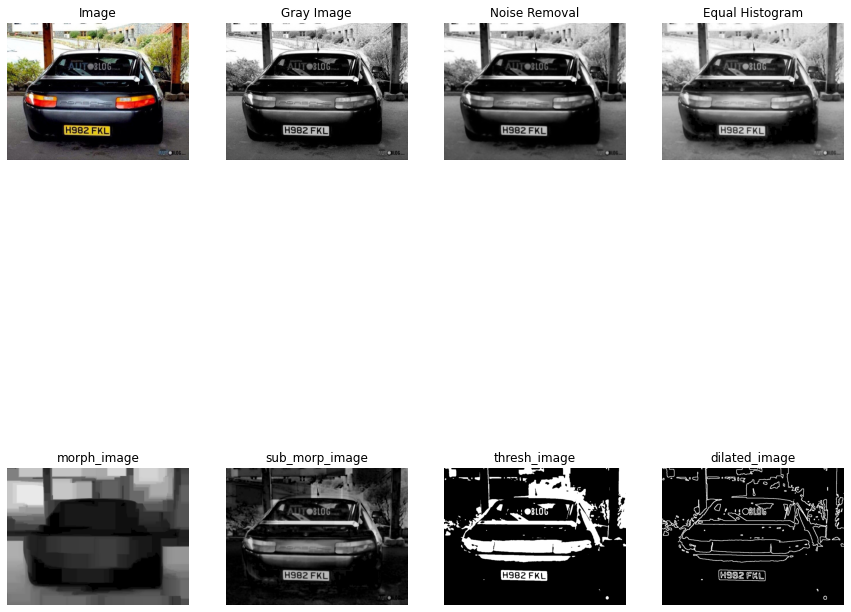

In [159]:
# Load image
im = cv2.imread("./image4.jpg")
im_copy = cv2.imread("./image4.jpg")

# Chuyển ảnh về không gian màu xám
im_gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)

# Giảm nhiễu làm cho các cạnh sắc nét hơn
noise_removal = cv2.bilateralFilter(im_gray,9,75,75)
# Cân bằng sáng tối hình ảnh
equal_histogram = cv2.equalizeHist(noise_removal)

# Biến đổi hình thái ảnh làm cho edge trở nên sắc nhọn
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
morph_image = cv2.morphologyEx(equal_histogram,cv2.MORPH_OPEN,kernel,iterations=20)

# Xóa background, tách biệt background và vùng sáng
sub_morp_image = cv2.subtract(equal_histogram,morph_image)
ret,thresh_image = cv2.threshold(sub_morp_image,0,255,cv2.THRESH_OTSU)

# Nhận dạng edge bằng thuật toán Canny
canny_image = cv2.Canny(thresh_image,250,255)

# Dilate các edge 
kernel = np.ones((3,3), np.uint8)
dilated_image = cv2.dilate(canny_image,kernel,iterations=1)


fig, axes = plt.subplots(2, 4, figsize=(15, 15))

axes[0][0].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
axes[0][0].set_title('Image')
axes[0][0].axis("off")
axes[0][1].imshow(cv2.cvtColor(im_gray, cv2.COLOR_BGR2RGB))
axes[0][1].set_title('Gray Image')
axes[0][1].axis("off")
axes[0][2].imshow(cv2.cvtColor(noise_removal, cv2.COLOR_BGR2RGB))
axes[0][2].set_title('Noise Removal')
axes[0][2].axis("off")
axes[0][3].imshow(cv2.cvtColor(equal_histogram, cv2.COLOR_BGR2RGB))
axes[0][3].set_title('Equal Histogram')
axes[0][3].axis("off")
axes[1][0].imshow(cv2.cvtColor(morph_image, cv2.COLOR_BGR2RGB))
axes[1][0].set_title('morph_image')
axes[1][0].axis("off")
axes[1][1].imshow(cv2.cvtColor(sub_morp_image, cv2.COLOR_BGR2RGB))
axes[1][1].set_title('sub_morp_image')
axes[1][1].axis("off")
axes[1][2].imshow(cv2.cvtColor(thresh_image, cv2.COLOR_BGR2RGB))
axes[1][2].set_title('thresh_image')
axes[1][2].axis("off")
axes[1][3].imshow(cv2.cvtColor(dilated_image, cv2.COLOR_BGR2RGB))
axes[1][3].set_title('dilated_image')
axes[1][3].axis("off")

In [160]:
# Tìm các countour từ dilated image
contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Lấy 10 contour có diện tích lớn nhất
contours= sorted(contours, key = cv2.contourArea, reverse = True)[:10]
location = None
for c in contours:
    peri = cv2.arcLength(c, True)
    # Xấp xỉ đa giác
    approx = cv2.approxPolyDP(c, 0.05 * peri, True) 
    # Nếu tìm được 4 đỉnh của hình chữ nhật -> lưu lại vị trí tọa độ 4 đỉnh
    if len(approx) == 4:
            location = approx
            break

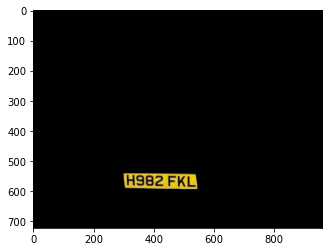

In [161]:
mask = np.zeros(im_gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(im, im, mask=mask)
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

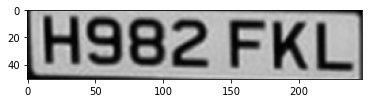

In [162]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
LpRegion = im_gray[x1:x2, y1:y2]
plt.imshow(cv2.cvtColor(LpRegion, cv2.COLOR_BGR2RGB))

In [163]:
roi = cv2.cvtColor(LpRegion, cv2.COLOR_BGR2RGB)
roi_gray = cv2.cvtColor(roi,cv2.COLOR_BGR2GRAY)
roi_blur = cv2.GaussianBlur(roi_gray,(3,3),1)
ret,thre = cv2.threshold(roi_blur,120,255,cv2.THRESH_BINARY_INV)
kerel3 = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
thre_mor = cv2.morphologyEx(thre,cv2.MORPH_DILATE,kerel3)
cont,hier = cv2.findContours(thre_mor,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

<ipython-input-164-682d3933c1e8>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours = np.array(contours)


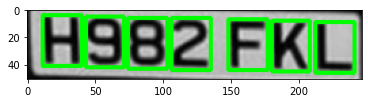

In [164]:
contour = max(cont, key=cv2.contourArea)
contours = []
for contour in cont:
    (x, y, w, h) = cv2.boundingRect(contour)

    # rule to determine characters
    aspectRatio = w / float(h)
    solidity = cv2.contourArea(contour) / float(w * h)
    heightRatio = h / float(LpRegion.shape[0])

    if 0.1 < aspectRatio < 1.0 and solidity > 0.1 and 0.6 < heightRatio < 1.0:
        cv2.rectangle(roi,(x,y),(x+w,y+h),(0,255,0),2)
        contours.append(contour)

contours = np.array(contours) 
        
plt.imshow(cv2.cvtColor(roi,cv2.COLOR_BGR2RGB))

In [165]:
contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

In [12]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

In [13]:
import keras
import numpy as np

def get_digits_data(path):
    data = np.load(path, allow_pickle=True)
    total_nb_data = len(data)
    np.random.shuffle(data)
    data_train = []

    for i in range(total_nb_data):
        data_train.append(data[i])

    print("-------------DONE------------")
    print('The number of train digits data: ', len(data_train))

    return data_train


def get_alphas_data(path):
    data = np.load(path, allow_pickle=True)
    total_nb_data = len(data)

    np.random.shuffle(data)
    data_train = []

    for i in range(total_nb_data):
        data_train.append(data[i])

    print("-------------DONE------------")
    print('The number of train alphas data: ', len(data_train))

    return data_train


class Datasets(object):
    def __init__(self):
        self.all_data = []

        # Input data
        self.digits_data = get_digits_data('./data/digits.npy')
        self.alphas_data = get_alphas_data('./data/alphas.npy')

        # Preprocess
        self.convert_data_format()

    def gen(self):
        np.random.shuffle(self.all_data)
        images = []
        labels = []

        for i in range(len(self.all_data)):
            image, label = self.all_data[i]
            images.append(image)
            labels.append(label)

        labels = keras.utils.to_categorical(labels, num_classes=32)
        return images, labels

    def convert_data_format(self):
        # Digits data
        for i in range(len(self.digits_data)):
            image = self.digits_data[i][0]
            label = self.digits_data[i][1]
            self.all_data.append((image, label))

        # Alpha data
        nb_alphas_data = len(self.alphas_data)
        for i in range(nb_alphas_data * 8):
            image = self.alphas_data[i % nb_alphas_data][0]
            label = self.alphas_data[i % nb_alphas_data][1]
            self.all_data.append((image, label))

In [14]:
dataset = Datasets()
trainX, trainY = dataset.gen()
X_train = np.array(trainX)
y_train = np.array(trainY)
X_train.shape

-------------DONE------------
The number of train digits data:  448
-------------DONE------------
The number of train alphas data:  628


(5472, 28, 28, 1)

In [167]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='softmax'))

In [168]:
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(1e-3), metrics=['acc'])

In [169]:
H = model.fit(X_train, y_train, validation_split=0.15, verbose=1,
                       epochs=10, shuffle=True, batch_size=128)

Epoch 1/10
37/37 [==============================] - 8s 228ms/step - loss: 2.8550 - acc: 0.1974 - val_loss: 1.6280 - val_acc: 0.6090
Epoch 2/10
37/37 [==============================] - 9s 233ms/step - loss: 1.2307 - acc: 0.6502 - val_loss: 0.4963 - val_acc: 0.8697
Epoch 3/10
37/37 [==============================] - 9s 233ms/step - loss: 0.5603 - acc: 0.8306 - val_loss: 0.2487 - val_acc: 0.9233
Epoch 4/10
37/37 [==============================] - 9s 235ms/step - loss: 0.3538 - acc: 0.8845 - val_loss: 0.2054 - val_acc: 0.9354
Epoch 5/10
37/37 [==============================] - 8s 227ms/step - loss: 0.2863 - acc: 0.9035 - val_loss: 0.1519 - val_acc: 0.9452
Epoch 6/10
37/37 [==============================] - 9s 252ms/step - loss: 0.2188 - acc: 0.9252 - val_loss: 0.1229 - val_acc: 0.9659
Epoch 7/10
37/37 [==============================] - 9s 238ms/step - loss: 0.1817 - acc: 0.9402 - val_loss: 0.0890 - val_acc: 0.9635
Epoch 8/10
37/37 [==============================] - 8s 227ms/step - loss: 0.

In [41]:
ALPHA_DICT = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'K', 9: 'L', 10: 'M', 11: 'N', 12: 'P',
              13: 'R', 14: 'S', 15: 'T', 16: 'U', 17: 'V', 18: 'X', 19: 'Y', 20: 'Z', 21: '0', 22: '1', 23: '2', 24: '3',
              25: '4', 26: '5', 27: '6', 28: '7', 29: '8', 30: '9', 31: "Background"}

res = ""
for contour in contours: 
    (x,y,w,h) = cv2.boundingRect(contour)
    roi = thre[y:y+h,x:x+w]
    roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
    roi = cv2.dilate(roi, (3, 3))
    num_pred = model.predict_on_batch(roi.reshape(1,28,28,1))
    num = ALPHA_DICT[np.argmax(num_pred)]
    res += num

In [19]:
ALPHA_DICT = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'K', 9: 'L', 10: 'M', 11: 'N', 12: 'P',
              13: 'R', 14: 'S', 15: 'T', 16: 'U', 17: 'V', 18: 'X', 19: 'Y', 20: 'Z', 21: '0', 22: '1', 23: '2', 24: '3',
              25: '4', 26: '5', 27: '6', 28: '7', 29: '8', 30: '9', 31: "Background"}

In [103]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)         

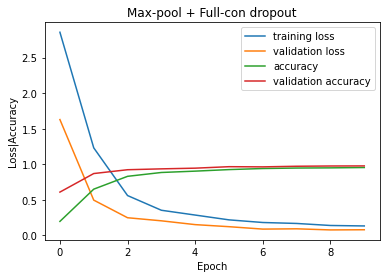

In [170]:
fig = plt.figure()
numOfEpoch = 10
plt.plot(np.arange(0, numOfEpoch), H.history['loss'], label='training loss')
plt.plot(np.arange(0, numOfEpoch), H.history['val_loss'], label='validation loss')
plt.plot(np.arange(0, numOfEpoch), H.history['acc'], label='accuracy')
plt.plot(np.arange(0, numOfEpoch), H.history['val_acc'], label='validation accuracy')
plt.title('Max-pool + Full-con dropout')
plt.xlabel('Epoch')
plt.ylabel('Loss|Accuracy')
plt.legend()

In [116]:
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(28, 28, 1)))
model1.add(Conv2D(32, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model1.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model1.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model1.add(Flatten())
model1.add(Dense(512, activation='relu'))
#model.add(Dropout(0.5))
model1.add(Dense(32, activation='softmax'))

model1.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(1e-3), metrics=['acc'])

In [117]:
H1 = model1.fit(X_train, y_train, validation_split=0.15, verbose=1,
                       epochs=10, shuffle=True, batch_size=128)

Epoch 1/10
37/37 [==============================] - 8s 207ms/step - loss: 1.2457 - acc: 0.6766 - val_loss: 0.1868 - val_acc: 0.9428
Epoch 2/10
37/37 [==============================] - 7s 200ms/step - loss: 0.1388 - acc: 0.9576 - val_loss: 0.1990 - val_acc: 0.9549
Epoch 3/10
37/37 [==============================] - 7s 199ms/step - loss: 0.0666 - acc: 0.9796 - val_loss: 0.0730 - val_acc: 0.9683
Epoch 4/10
37/37 [==============================] - 8s 221ms/step - loss: 0.0430 - acc: 0.9841 - val_loss: 0.0441 - val_acc: 0.9781
Epoch 5/10
37/37 [==============================] - 8s 216ms/step - loss: 0.0193 - acc: 0.9929 - val_loss: 0.0374 - val_acc: 0.9854
Epoch 6/10
37/37 [==============================] - 7s 196ms/step - loss: 0.0132 - acc: 0.9959 - val_loss: 0.0282 - val_acc: 0.9903
Epoch 7/10
37/37 [==============================] - 7s 198ms/step - loss: 0.0235 - acc: 0.9918 - val_loss: 0.0187 - val_acc: 0.9951
Epoch 8/10
37/37 [==============================] - 7s 199ms/step - loss: 0.

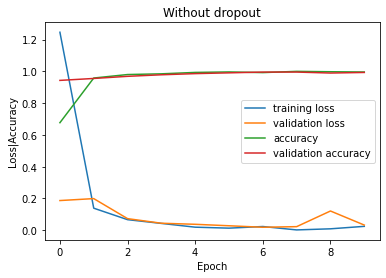

In [118]:
fig = plt.figure()
numOfEpoch = 10
plt.plot(np.arange(0, numOfEpoch), H1.history['loss'], label='training loss')
plt.plot(np.arange(0, numOfEpoch), H1.history['val_loss'], label='validation loss')
plt.plot(np.arange(0, numOfEpoch), H1.history['acc'], label='accuracy')
plt.plot(np.arange(0, numOfEpoch), H1.history['val_acc'], label='validation accuracy')
plt.title('Without dropout')
plt.xlabel('Epoch')
plt.ylabel('Loss|Accuracy')
plt.legend()

In [179]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(1e-3), metrics=['acc'])

In [180]:
H = model.fit(X_train, y_train, validation_split=0.15, verbose=1,
                       epochs=10, shuffle=True, batch_size=128)

Epoch 1/10
37/37 [==============================] - 10s 264ms/step - loss: 2.8897 - acc: 0.1853 - val_loss: 1.6824 - val_acc: 0.5043
Epoch 2/10
37/37 [==============================] - 11s 306ms/step - loss: 1.2971 - acc: 0.6154 - val_loss: 0.4928 - val_acc: 0.8563
Epoch 3/10
37/37 [==============================] - 12s 330ms/step - loss: 0.5843 - acc: 0.8175 - val_loss: 0.2192 - val_acc: 0.9318
Epoch 4/10
37/37 [==============================] - 12s 333ms/step - loss: 0.3984 - acc: 0.8676 - val_loss: 0.1427 - val_acc: 0.9354
Epoch 5/10
37/37 [==============================] - 12s 336ms/step - loss: 0.3086 - acc: 0.8996 - val_loss: 0.0967 - val_acc: 0.9635
Epoch 6/10
37/37 [==============================] - 12s 328ms/step - loss: 0.2417 - acc: 0.9164 - val_loss: 0.0883 - val_acc: 0.9708
Epoch 7/10
37/37 [==============================] - 12s 323ms/step - loss: 0.2281 - acc: 0.9273 - val_loss: 0.0709 - val_acc: 0.9756
Epoch 8/10
37/37 [==============================] - 12s 324ms/step - 

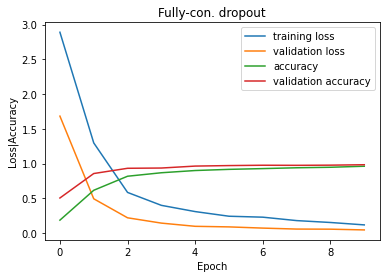

In [181]:
fig = plt.figure()
numOfEpoch = 10
plt.plot(np.arange(0, numOfEpoch), H.history['loss'], label='training loss')
plt.plot(np.arange(0, numOfEpoch), H.history['val_loss'], label='validation loss')
plt.plot(np.arange(0, numOfEpoch), H.history['acc'], label='accuracy')
plt.plot(np.arange(0, numOfEpoch), H.history['val_acc'], label='validation accuracy')
plt.title('Fully-con. dropout')
plt.xlabel('Epoch')
plt.ylabel('Loss|Accuracy')
plt.legend()

In [120]:
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(28, 28, 1)))
model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
#model.add(Dropout(0.5))
model2.add(Dense(32, activation='softmax'))

model2.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(1e-3), metrics=['acc'])

In [126]:
H2 = model2.fit(X_train, y_train, validation_split=0.15, verbose=1,
                       epochs=10, shuffle=True, batch_size=128)

Epoch 1/10
37/37 [==============================] - 8s 213ms/step - loss: 2.4815 - acc: 0.3208 - val_loss: 0.8747 - val_acc: 0.8002
Epoch 2/10
37/37 [==============================] - 8s 221ms/step - loss: 0.6819 - acc: 0.7955 - val_loss: 0.2079 - val_acc: 0.9281
Epoch 3/10
37/37 [==============================] - 8s 203ms/step - loss: 0.2755 - acc: 0.9091 - val_loss: 0.1163 - val_acc: 0.9622
Epoch 4/10
37/37 [==============================] - 8s 220ms/step - loss: 0.1978 - acc: 0.9323 - val_loss: 0.1286 - val_acc: 0.9574
Epoch 5/10
37/37 [==============================] - 8s 204ms/step - loss: 0.1744 - acc: 0.9415 - val_loss: 0.0787 - val_acc: 0.9671
Epoch 6/10
37/37 [==============================] - 8s 219ms/step - loss: 0.1211 - acc: 0.9561 - val_loss: 0.0801 - val_acc: 0.9769
Epoch 7/10
37/37 [==============================] - 8s 217ms/step - loss: 0.1062 - acc: 0.9688 - val_loss: 0.0688 - val_acc: 0.9647
Epoch 8/10
37/37 [==============================] - 8s 216ms/step - loss: 0.

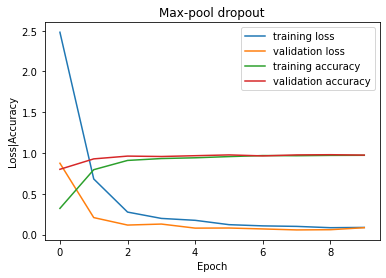

In [127]:
fig = plt.figure()
numOfEpoch = 10
plt.plot(np.arange(0, numOfEpoch), H2.history['loss'], label='training loss')
plt.plot(np.arange(0, numOfEpoch), H2.history['val_loss'], label='validation loss')
plt.plot(np.arange(0, numOfEpoch), H2.history['acc'], label='training accuracy')
plt.plot(np.arange(0, numOfEpoch), H2.history['val_acc'], label='validation accuracy')
plt.title('Max-pool dropout')
plt.xlabel('Epoch')
plt.ylabel('Loss|Accuracy')
plt.legend()

In [45]:
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(28, 28, 1)))
model3.add(Dropout(0.25))
model3.add(Conv2D(32, (3, 3), activation='relu'))
model3.add(Dropout(0.25))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model3.add(Dropout(0.25))
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(Dropout(0.25))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model3.add(Dropout(0.25))
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(Dropout(0.25))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())
model3.add(Dense(512, activation='relu'))
#model.add(Dropout(0.5))
model3.add(Dense(32, activation='softmax'))

model3.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(1e-3), metrics=['acc'])

In [46]:
H3 = model3.fit(X_train, y_train, validation_split=0.15, verbose=1,
                       epochs=10, shuffle=True, batch_size=128)

Epoch 1/10
37/37 [==============================] - 12s 332ms/step - loss: 2.5322 - acc: 0.3518 - val_loss: 1.4534 - val_acc: 0.8124
Epoch 2/10
37/37 [==============================] - 11s 307ms/step - loss: 0.5668 - acc: 0.8338 - val_loss: 0.5459 - val_acc: 0.9147
Epoch 3/10
37/37 [==============================] - 12s 326ms/step - loss: 0.2693 - acc: 0.9024 - val_loss: 0.2906 - val_acc: 0.9537
Epoch 4/10
37/37 [==============================] - 12s 328ms/step - loss: 0.1874 - acc: 0.9357 - val_loss: 0.2441 - val_acc: 0.9635
Epoch 5/10
37/37 [==============================] - 13s 338ms/step - loss: 0.1603 - acc: 0.9482 - val_loss: 0.2084 - val_acc: 0.9695
Epoch 6/10
37/37 [==============================] - 13s 346ms/step - loss: 0.1496 - acc: 0.9510 - val_loss: 0.2114 - val_acc: 0.9708
Epoch 7/10
37/37 [==============================] - 13s 340ms/step - loss: 0.1176 - acc: 0.9611 - val_loss: 0.2025 - val_acc: 0.9732
Epoch 8/10
37/37 [==============================] - 11s 310ms/step - 

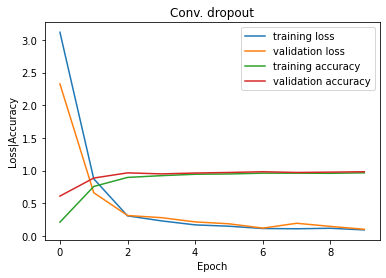

In [182]:
fig = plt.figure()
numOfEpoch = 10
plt.plot(np.arange(0, numOfEpoch), H3.history['loss'], label='training loss')
plt.plot(np.arange(0, numOfEpoch), H3.history['val_loss'], label='validation loss')
plt.plot(np.arange(0, numOfEpoch), H3.history['acc'], label='training accuracy')
plt.plot(np.arange(0, numOfEpoch), H3.history['val_acc'], label='validation accuracy')
plt.title('Conv. dropout')
plt.xlabel('Epoch')
plt.ylabel('Loss|Accuracy')
plt.legend()

Epoch 1/10
37/37 [==============================] - 11s 305ms/step - loss: 1.7009 - acc: 0.5448 - val_loss: 0.3279 - val_acc: 0.9184
Epoch 2/10
37/37 [==============================] - 11s 299ms/step - loss: 0.2298 - acc: 0.9282 - val_loss: 0.2054 - val_acc: 0.9428
Epoch 3/10
37/37 [==============================] - 11s 303ms/step - loss: 0.1144 - acc: 0.9619 - val_loss: 0.0962 - val_acc: 0.9659
Epoch 4/10
37/37 [==============================] - 11s 290ms/step - loss: 0.0930 - acc: 0.9708 - val_loss: 0.0820 - val_acc: 0.9756
Epoch 5/10
37/37 [==============================] - 10s 283ms/step - loss: 0.0652 - acc: 0.9781 - val_loss: 0.0526 - val_acc: 0.9890
Epoch 6/10
37/37 [==============================] - 11s 287ms/step - loss: 0.0570 - acc: 0.9800 - val_loss: 0.0630 - val_acc: 0.9829
Epoch 7/10
37/37 [==============================] - 11s 293ms/step - loss: 0.0568 - acc: 0.9830 - val_loss: 0.0685 - val_acc: 0.9781
Epoch 8/10
37/37 [==============================] - 11s 289ms/step - 

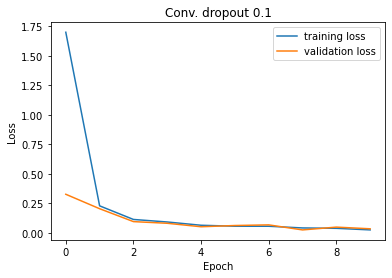

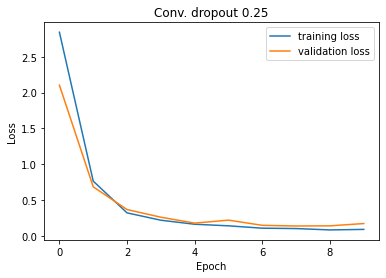

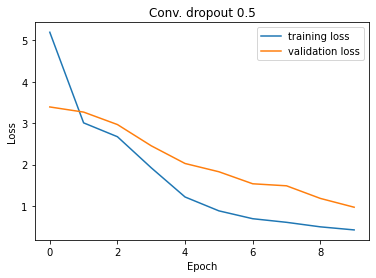

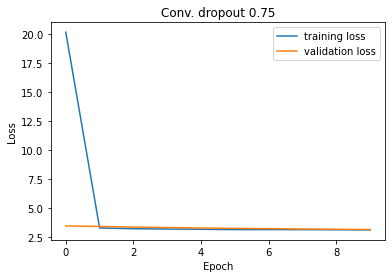

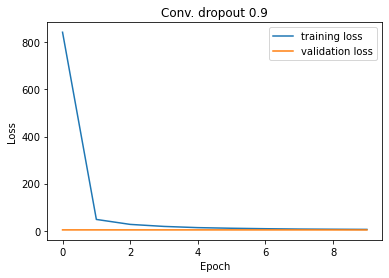

In [132]:
dropouts = [0.1, 0.25, 0.5, 0.75, 0.9]
numOfEpoch = 10


for dropout in dropouts:
    model4 = Sequential()
    model4.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(28, 28, 1)))
    model4.add(Dropout(dropout))
    model4.add(Conv2D(32, (3, 3), activation='relu'))
    model4.add(Dropout(dropout))
    model4.add(MaxPooling2D(pool_size=(2, 2)))

    model4.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model4.add(Dropout(dropout))
    model4.add(Conv2D(64, (3, 3), activation='relu'))
    model4.add(Dropout(dropout))
    model4.add(MaxPooling2D(pool_size=(2, 2)))

    model4.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model4.add(Dropout(dropout))
    model4.add(Conv2D(64, (3, 3), activation='relu'))
    model4.add(Dropout(dropout))
    model4.add(MaxPooling2D(pool_size=(2, 2)))

    model4.add(Flatten())
    model4.add(Dense(512, activation='relu'))
    #model.add(Dropout(0.5))
    model4.add(Dense(32, activation='softmax'))
    
    model4.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(1e-3), metrics=['acc'])
    H4 = model4.fit(X_train, y_train, validation_split=0.15, verbose=1,
                       epochs=10, shuffle=True, batch_size=128)
    
    fig = plt.figure()
    plt.plot(np.arange(0, numOfEpoch), H4.history['loss'], label='training loss')
    plt.plot(np.arange(0, numOfEpoch), H4.history['val_loss'], label='validation loss')
   # plt.plot(np.arange(0, numOfEpoch), H3.history['acc'], label='training accuracy')
   # plt.plot(np.arange(0, numOfEpoch), H3.history['val_acc'], label='validation accuracy')
    plt.title(f'Conv. dropout {dropout}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

Text(0.5, 1.0, 'CNN')

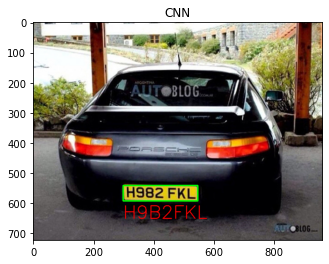

In [166]:
res = ""
for contour in contours: 
    (x,y,w,h) = cv2.boundingRect(contour)
    roi = thre[y:y+h,x:x+w]
    roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
    roi = cv2.dilate(roi, (3, 3))
    num_pred = model.predict_on_batch(roi.reshape(1,28,28,1))
    num = ALPHA_DICT[np.argmax(num_pred)]
    res += num

font = cv2.FONT_HERSHEY_SIMPLEX
out2 = cv2.putText(im_copy, text=res, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=2, color=(0,0,255), thickness=2, lineType=cv2.LINE_AA)
out2 = cv2.rectangle(im_copy, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(out2, cv2.COLOR_BGR2RGB))
plt.title("CNN")